In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker, FoVBackgroundMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 1.0 * u.hr
l = 0.05
pointing = SkyCoord(141.409467, 40.566962, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(141.409467, 40.566962),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

In [8]:
# Define sky model to used simulate the data.
# Here we use a Point spatial model and a Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.495, amplitude="2.72e-13 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.495              
    amplitude               :   2.72e-13  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [9]:
def FoV(energy_reco, energy_true, livetime, irfs, pointing, geom, models):
    model = models.copy()
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(random_state=42)
    
    dataset1 = dataset.copy()
    dataset1.models = bkg_model
    
    estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
    lima_maps = estimator.run(dataset1)
    significance_map = lima_maps["sqrt_ts"]
    excess_map = lima_maps["excess"]
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
    
    ## original code
    dataset1 = maker_fov.run(dataset1)
    
    TS0 = dataset1.stat_sum()
    models_fit = model[0].copy()
    dataset1.models = models_fit
    fit = Fit([dataset1])
    result = fit.run()
    print(result)
    TS1 = dataset1.stat_sum()
    del_TS = TS0 - TS1
    
    return del_TS, dataset1, models_fit, significance_map, excess_map

In [10]:
def ring1(energy_reco, energy_true, livetime, irfs, pointing, geom, models):
    model = models.copy()
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(random_state=42)
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    ring_maker = RingBackgroundMaker(
        r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
    )
    dataset_on_off = MapDatasetOnOff.create(
        geom=geom_image, energy_axis_true=energy_true, name="stacked"
    )
    dataset_on_off = ring_maker.run(dataset.to_image())
    
    TS0 = dataset_on_off.stat_sum()
    dataset_on_off.models = model
    fit = Fit([dataset_on_off])
    result = fit.run()
    print(result)
    TS1 = dataset_on_off.stat_sum()
    del_TS = TS0 - TS1
    
    return del_TS, dataset_on_off, model, dataset

In [11]:
def ring2(energy_reco, energy_true, livetime, irfs, pointing, geom, models):
    model = models.copy()
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(random_state=42)
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    ring_maker = RingBackgroundMaker(
        r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
    )
    dataset = ring_maker.run(dataset) ## Instead of default dataset.to_image, only dataset is taken
    
    TS0 = dataset.stat_sum()
    dataset.models = model
    fit = Fit([dataset])
    result = fit.run()
    print(result)
    TS1 = dataset.stat_sum()
    del_TS = TS0 - TS1
    
    return del_TS, dataset, model

In [12]:
def excess_maps(significance_map, excess_map):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
    ax2 = plt.subplot(222, projection=excess_map.geom.wcs)
    
    ax1.set_title("Significance map")
    significance_map.plot(ax=ax1, add_cbar=True)

    ax2.set_title("Excess map")
    excess_map.plot(ax=ax2, add_cbar=True)
    return

In [13]:
x = [25.0,50.0,10.0,200.0,500.0] * u.hr
y1 = []
y2 = []
y3 = []

In [14]:
for i in range(len(x)):
    y1.append(FoV(energy_reco, energy_true, x[i], irfs, pointing, geom, models))
    y2.append(ring1(energy_reco, energy_true, x[i], irfs, pointing, geom, model_simu))
    y3.append(ring2(energy_reco, energy_true, x[i], irfs, pointing, geom, model_simu))

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 110
	total stat : -1462994.32

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 104
	total stat : 22539.17

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 107
	total stat : 179247.66

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 140
	total stat : -4811556.19

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 106
	total stat : 22563.86

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev    

In [15]:
del_TS_ = []
dataset_ = []
model_ = []
significance_ = []
excess_ = []
for i in range(len(x)):
    del_TS_.append(y1[i][0])
    dataset_.append(y1[i][1])
    model_.append(y1[i][2])
    significance_.append(y1[i][3])
    excess_.append(y1[i][4])
    
for i in range(len(x)):
    del_TS_.append(y2[i][0])
    dataset_.append(y2[i][3])
    model_.append(y2[i][2])
    
for i in range(len(x)):
    del_TS_.append(y3[i][0])
    dataset_.append(y3[i][1])
    model_.append(y3[i][2])

In [16]:
print(del_TS_[0:5])
print(del_TS_[5:10])
print(del_TS_[10:15])

[1507.6534783621319, 2680.8004509638995, 508.1142427546438, 11150.176214434206, 27743.132700026035]
[799.7235525751021, 1444.8590310183354, 262.3565373249585, 5857.253478627652, 14786.425593055785]
[1507.144063462125, 2671.2633523138356, 509.7862557108165, 11159.522912525223, 27689.70072310604]


Text(0.5, 1.0, 'Original code')

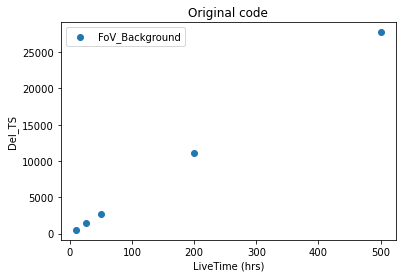

In [17]:
plt.scatter(x,del_TS_[0:5])
#plt.xscale("log")
plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Original code")

Text(0.5, 1.0, 'Original code')

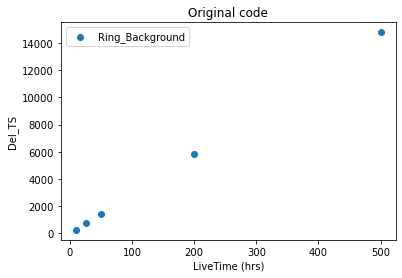

In [18]:
plt.scatter(x,del_TS_[5:10])
#plt.xscale("log")
plt.legend(["Ring_Background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Original code")

Text(0.5, 1.0, 'Instead of default dataset.to_image, only dataset is taken')

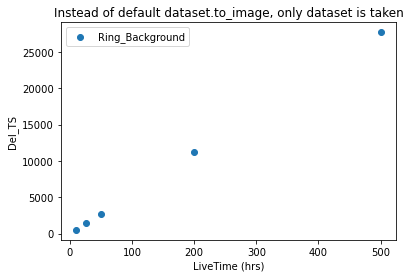

In [19]:
plt.scatter(x,del_TS_[10:15])
plt.legend(["Ring_Background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Instead of default dataset.to_image, only dataset is taken")

In [20]:
def flux_plt(model, dataset):
    spec = model.spectral_model
    energy_edges = np.logspace(-1.0, 1.0, 5) * u.TeV
    fpe = FluxPointsEstimator(energy_edges=energy_edges)
    flux_points = fpe.run(datasets=[dataset])
    energy_range = [0.1, 10] * u.TeV
    spec.plot(energy_range=energy_range, energy_power=2)
    ax = spec.plot_error(energy_range=energy_range, energy_power=2)
    flux_points.plot(ax=ax, energy_power=2)
    plt.title("Livetime = "+str(dataset.gti.time_delta.to(u.hr)))#, fontsize='15')
    return

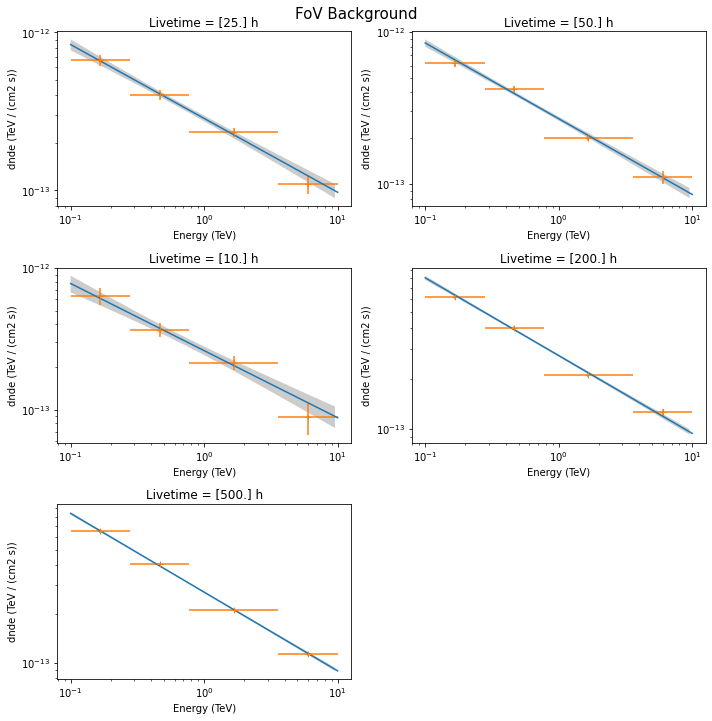

In [21]:
fig = plt.figure(figsize = [10,10], tight_layout=True)
fig.suptitle('FoV Background', verticalalignment = 'baseline', fontsize = 15)
plt.subplot(321)
flux_plt(model_[0],dataset_[0])
plt.subplot(322)
flux_plt(model_[1],dataset_[1])
plt.subplot(323)
flux_plt(model_[2],dataset_[2])
plt.subplot(324)
flux_plt(model_[3],dataset_[3])
plt.subplot(325)
flux_plt(model_[4],dataset_[4])

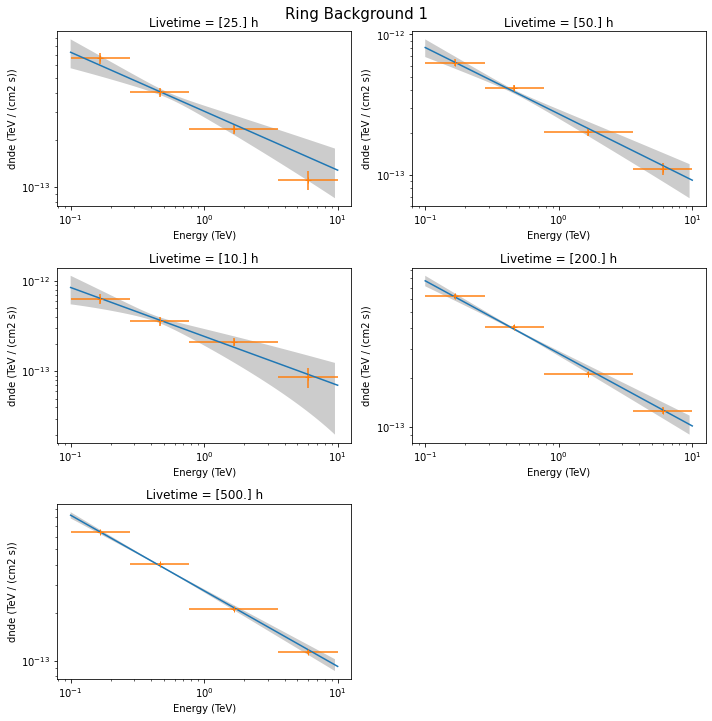

In [22]:
fig = plt.figure(figsize = [10,10], tight_layout=True)
fig.suptitle('Ring Background 1', verticalalignment = 'baseline', fontsize = 15)
plt.subplot(321)
flux_plt(model_[5],dataset_[5])
plt.subplot(322)
flux_plt(model_[6],dataset_[6])
plt.subplot(323)
flux_plt(model_[7],dataset_[7])
plt.subplot(324)
flux_plt(model_[8],dataset_[8])
plt.subplot(325)
flux_plt(model_[9],dataset_[9])

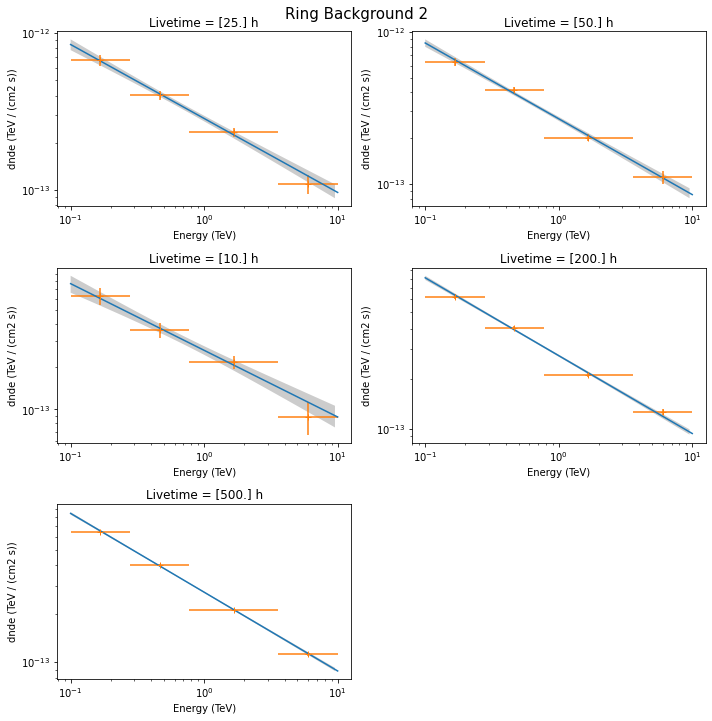

In [23]:
fig = plt.figure(figsize = [10,10], tight_layout=True)
fig.suptitle('Ring Background 2', verticalalignment = 'baseline', fontsize = 15)
plt.subplot(321)
flux_plt(model_[10],dataset_[10])
plt.subplot(322)
flux_plt(model_[11],dataset_[11])
plt.subplot(323)
flux_plt(model_[12],dataset_[12])
plt.subplot(324)
flux_plt(model_[13],dataset_[13])
plt.subplot(325)
flux_plt(model_[14],dataset_[14])

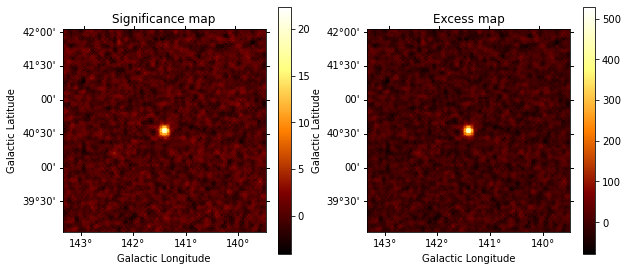

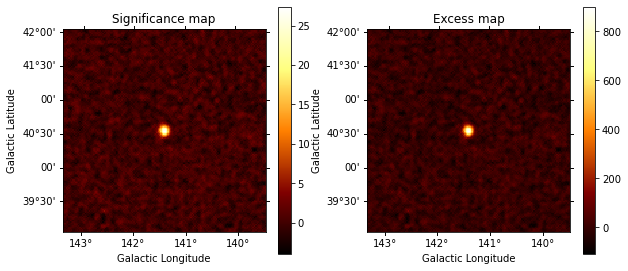

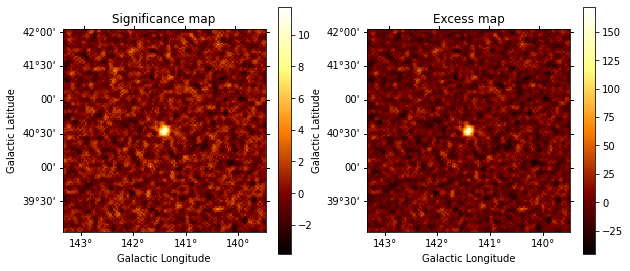

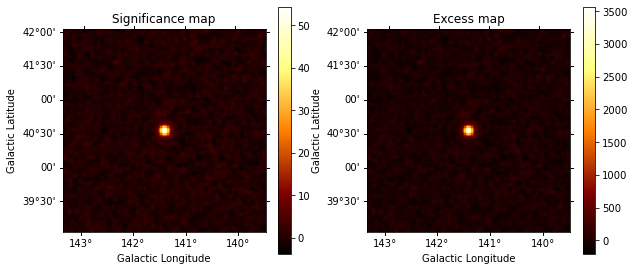

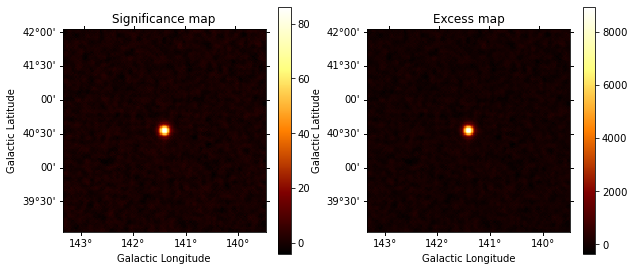

In [24]:
excess_maps(significance_[0], excess_[0])
excess_maps(significance_[1], excess_[1])
excess_maps(significance_[2], excess_[2])
excess_maps(significance_[3], excess_[3])
excess_maps(significance_[4], excess_[4])